This notebook is part of the thesis R. Dijkstra OU BPMIT and based on the definition of the gap of change 
visialized in ArchiMate according Bakelaar et al 2017.
The code is written in a style to match the definition as much as possible. Code is redundant for more better
readability.

This version proposes extended_by relations.

Changes are defined by assigning a component to either AsIs or ToBe.
Assigning relationships to AsIs or Tobe is only needed when relating components are changed, and
the change of the relation must be analysed.

The next view is from the Archisurance case.

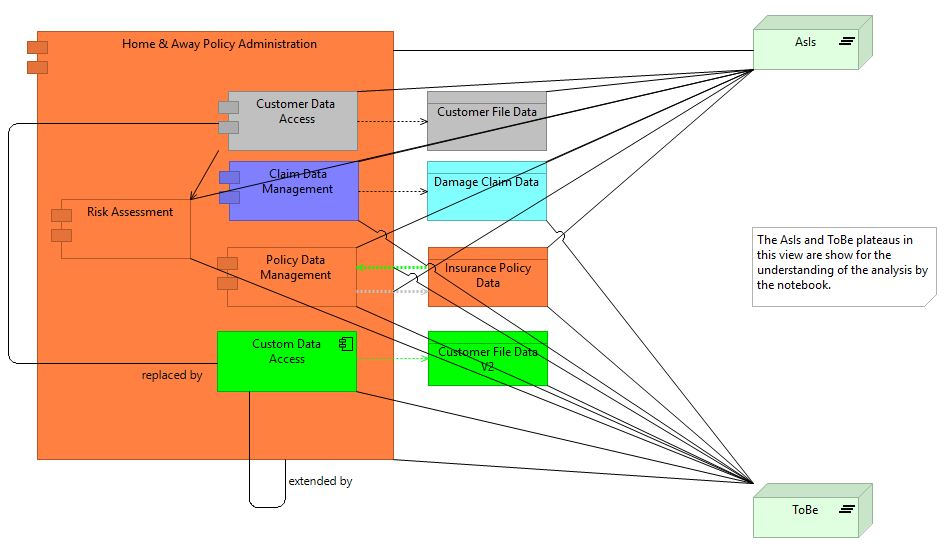

In [1]:
import pandas as pd

# Parameters
PREFIX = 'surance-'  # for importing a the Archisurance model with one change
#PREFIX = 'test1-'  # for importing small test model

NAME_ASIS = 'AsIs'
NAME_TOBE = 'ToBe'

In [2]:
class Element:
    """Element : id, name, type"""
    def __init__(self, id, element_type, name):
        self.id = id
        self.name = name
        self.element_type = element_type
        
        self.relation_asis_ids = set()
        self.relation_tobe_ids = set()
        self.relation_other_ids = set()
        
        self.obsolete = False
        self.new = False
        self.changed = False
        self.unchanged = False
        self.border = False
        self.is_part_of_asis = False
        self.is_part_of_tobe = False
        
        self.core = True
        
        self.border = False
        
    def set_is_part_of_asis(self, asis, relations_dict):
        # if element has a relation with asis then True
        for key, relation in relations_dict.items():
            if (relation.source == self.id and relation.target == asis.id) or \
               (relation.source == asis.id and relation.target == self.id):
                self.is_part_of_asis = True
 
    def set_is_part_of_tobe(self, tobe, relations_dict):
        # if element has a relation with tobe then True
        for key, relation in relations_dict.items(): 
            if (relation.source == self.id and relation.target == tobe.id) or \
               (relation.source == tobe.id and relation.target == self.id):
                self.is_part_of_tobe = True
                
    def __repr__(self): 
        return f'{self.id}, {self.element_type}, {self.name}'
            
        
class Relation:
    """Element : id, name, type, source, target"""
    def __init__(self, id, relation_type, name, source, target):
        self.name = name
        self.id = id
        self.relation_type = relation_type
        self.source = source
        self.target = target
        
        self.is_part_of_asis = False
        self.is_part_of_tobe = False
        self.obsolete = False
        self.new = False
        
        self.core = True
        self.rel_to_rel = False
        
        self.border = False
        self.extended_by = False
        self.replaced_by = False
        
    def __repr__(self):
        return f'{self.id}, {self.relation_type}, {self.is_part_of_asis}, \
                {self.is_part_of_tobe}, {elements_dict[self.source].name}, \
                {elements_dict[self.target].name}'

        
set_asis_relations = set()
set_tobe_relations = set()

set_asis_elements = set()
set_tobe_elements = set()

set_obsolete_elements = set()
set_new_elements = set()
set_border_elements = set()

set_changed_elements = set()
set_unchanged_elements = set()

set_obsolete_relations = set()
set_new_relations = set()

set_extended_by_relations = set()
set_replaced_by_relations = set()
set_border_relations = set()


In [3]:
# Import ArchiMate model from Architool exports.
# ----------------------------------------------
df_elements = pd.read_csv(f'{PREFIX}elements.csv', sep=";")
elements_dict = dict()

for index, element in df_elements.iterrows():
    e = Element(element.ID, element.Type, element.Name)
    if (e.element_type not in \
        ['ArchimateModel', 'Goal', 'Stakeholder', 'Constraint', 'Requirement', 'Driver']):
        # Deny non-core 'Plateau' and other non-core concepts for defining changed
        elements_dict[e.id] = e
                

# Create asis and tobe object for further use
# -------------------------------------------
for id, element in elements_dict.items():
    if element.name == NAME_TOBE: # and element.element_type == 'Plateau':
        tobe = element

    if element.name == NAME_ASIS:# and element.element_type == 'Plateau':
        asis = element

# Import relationships
# --------------------
df_relations = pd.read_csv(f'{PREFIX}relations.csv', sep=";")
relations_dict = dict()

for index, relation in df_relations.iterrows():
    if relation.Source in elements_dict.keys() and relation.Target in elements_dict.keys():
        r = Relation(relation.ID, relation.Type, relation.Name, relation.Source, relation.Target)
        if relation.Name in ['replaced by', 'extended by']:
            # Exclude these GOC relations from the ArchiMate standard model.
            r.core = False
        relations_dict[r.id]=r
        
    # Relation may exist between relations and elements, source is relation
    if relation.Source in relations_dict.keys() and relation.Target in elements_dict.keys():
        r = Relation(relation.ID, relation.Type, relation.Name, relation.Source, relation.Target)
        r.rel_to_rel = True
        if relation.Name in ['replaced by', 'extended by'] or \
                (r.target in [asis.id, tobe.id]):
            # Exclude these GOC relations from the ArchiMate standard model.
            r.core = False
        relations_dict[r.id]=r

In [4]:
 
# Set part of asis/tobe attribute
# -------------------------------
for key, element in elements_dict.items():
    element.set_is_part_of_asis(asis, relations_dict)
    element.set_is_part_of_tobe(tobe, relations_dict)

    
# Create set of asis elements
# ---------------------------
for key, element in elements_dict.items():
    if element.is_part_of_asis:
        set_asis_elements.add(element.id)

for key, element in elements_dict.items():
    if element.is_part_of_tobe:
        set_tobe_elements.add(element.id)

# Find and set extended_by relationships
# --------------------------------------
# Assiciations or specialisations with the name 'extended by'
for key, relation in relations_dict.items():
    if relation.name == 'extended by':
        relation.extended_by = True
    else:
        relation.extended_by = False
    
    
# Find and set replaced_by relationships
# --------------------------------------
# Assiciations or specialisations with the name 'replaced by'
for key, relation in relations_dict.items():
    if relation.name == 'replaced by':
        relation.replaced_by = True
    else:
        relation.replaced_by = False

        
# Assign relation to asis and/or to be based on source and target elements, 
# relation to plateau is not needed.
# -------------------------------------------------------------------------
for key, relation in relations_dict.items():
    # relation ids may also be source and or target
    if relation.rel_to_rel == False:
        if elements_dict[relation.source].is_part_of_asis and elements_dict[relation.target].is_part_of_asis:
            relation.is_part_of_asis = True
        if elements_dict[relation.source].is_part_of_tobe and elements_dict[relation.target].is_part_of_tobe:
            relation.is_part_of_tobe = True
    else: 
        # When relation to relation is processed, the source relation is the relevant model relation
        arch_relation = relations_dict[relation.source]
        if relation.target == asis.id:
            arch_relation.obsolete = True
        if relation.target == tobe.id:
            arch_relation.new = True

In [5]:
# Create Rasis and Rtobe 
# ----------------------
for key, relation in relations_dict.items():
    if relation.is_part_of_asis == True:
        set_asis_relations.add(relations_dict[key].id)
    if relation.is_part_of_tobe == True:
        set_tobe_relations.add(relations_dict[key].id)
        
        
# Add relations to elements: from and to
# --------------------------------------
for element_key, element in elements_dict.items():
    for relation_key, relation in relations_dict.items():
#         _target = elements_dict[relation.target]
#         _source = elements_dict[relation.source]
        if element.is_part_of_asis and relation.is_part_of_asis \
                and (relation.source == element.id or relation.target == element.id):
            element.relation_asis_ids.add(relation_key)
        if element.is_part_of_tobe and relation.is_part_of_tobe \
                and (relation.source == element.id or relation.target == element.id):
            element.relation_tobe_ids.add(relation_key)
        if (not element.is_part_of_asis) and (not relation.is_part_of_asis) \
                and (relation.source == element.id or relation.target == element.id):
            element.relation_other_ids.add(relation_key)

# Set unchanged elements as such, partly because later set to changed relations may add elements.
# -----------------------------------------------------------------------------------------------
for key, element in elements_dict.items():
   
    if (element.relation_asis_ids == element.relation_tobe_ids) and \
            (element.element_type != 'Plateau'):
        element.unchanged = True
    else:
        element.unchanged = False
        
    if element.relation_asis_ids != element.relation_tobe_ids and \
            (not element.new) and (not element.obsolete) and \
            (element.element_type != 'Plateau'):
        element.changed = True
    else:
        element.changed = False


                
# Set obsolete elements as such
# -----------------------------
for key, element in elements_dict.items():
    #element.set_obsolete()
    if element.is_part_of_asis and not element.is_part_of_tobe:
        elements_dict[key].obsolete = True
        
    
# Set new elements as such
# ------------------------
for key, element in elements_dict.items():
    #element.set_new()
    if not element.is_part_of_asis and element.is_part_of_tobe:
        elements_dict[key].new = True


In [6]:
# Set asis relationships to obsolete when element is obsolete
# -----------------------------------------------------------
for element_id in set_asis_elements:
    element = elements_dict[element_id]
    if element.obsolete == True:
        for relation_id in element.relation_asis_ids:
            relations_dict[relation_id].obsolete = True

            
# Set tobe relationships to new when element is new
# -------------------------------------------------
for element_id in set_tobe_elements:
    element = elements_dict[element_id]
    if element.new == True:
        for relation_id in element.relation_tobe_ids:
            relations_dict[relation_id].new = True

In [7]:
# Set border attribute (When unchanged and having relation to changed object or new or obsolete object)
# -----------------------------------------------------------------------------------------------------
for element_key, element in elements_dict.items():
    # For modelling only a part of a larger EA, border elements do not have to be part of AsIs
    for relation_key in element.relation_asis_ids | element.relation_tobe_ids | element.relation_other_ids:
    #for relation_key, relation in relations_dict.items():
        relation = relations_dict[relation_key]
        if relation.rel_to_rel == False:
            relation = relations_dict[relation_key]
            source = elements_dict[relation.source]
            target = elements_dict[relation.target]
            
        if relation.rel_to_rel == True:
            relation = relations_dict[relation_key]
            source = relations_dict[relation.source]#
            target = elements_dict[relation.target]   
            if relation.new == True or relation.obsolete == True:
                # relation from relation to tobe or asis
                source.changed = True
                target.changed = True
            
        if element.unchanged and (target.changed or source.changed): 
            element.border = True
            relation.border = True
            #relations_dict[relation_key].border = True, changed to relation.border



In [8]:
# Create set obsolete elements
# ----------------------------
for key, element in elements_dict.items():
    if element.obsolete == True:
        set_obsolete_elements.add(element.id)

        
# Create set new elements
# -----------------------
for key, element in elements_dict.items():
    if element.new == True:
        set_new_elements.add(element.id)
        

# Create set changed elements
# ---------------------------
for key, element in elements_dict.items():
    if element.changed == True:
        set_changed_elements.add(element.id)

        
# Create set unchanged elements
# -----------------------------
for key, element in elements_dict.items():
    if element.unchanged == True:
        set_unchanged_elements.add(element.id)

        
# Create set border elements, can be element without being part of AsIs
# ---------------------------------------------------------------------
for key, element in elements_dict.items():
    if element.border == True:
        set_border_elements.add(element.id)
        
        
# Create set replaced by relationships
# ------------------------------------
for key, relation in relations_dict.items():
    if relation.replaced_by == True:
        set_replaced_by_relations.add(relation.id)
        
        
# Create set extended by relationships
# ------------------------------------
for key, relation in relations_dict.items():
    if relation.extended_by == True:
        set_extended_by_relations.add(relation.id)

        
# Create set border relationships
# ------------------------------------
for key, relation in relations_dict.items():
    if relation.border == True:
        set_border_relations.add(relation.id)


#Create set obsolete relationships
# ---------------------------------
for relation_id, relation in relations_dict.items():
    if relation.obsolete == True and relation.core == True:
        set_obsolete_relations.add(relation_id)


# Create set new relationships
# Exclude non-core relationships extended by and replaced by
# -----------------------------------------------------------
for relation_id, relation in relations_dict.items():
    if relation.new == True and relation.core == True:
        set_new_relations.add(relation_id)


In [9]:
# Create dataframe for printing and counting
# ------------------------------------------
relation_df_columns = ['source', 'source_type', 'target', 'target_type', 'relation_type', 'state']
goc_elements_df = pd.DataFrame(data=[], columns=['object_type', 'state', 'name'])
goc_relations_df = pd.DataFrame(data=[], columns=relation_df_columns)

element_sets =   [(set_new_elements, 'new object'), 
                 (set_obsolete_elements, 'obsolete object'),
                 (set_changed_elements, 'changed object'),
                 (set_unchanged_elements, 'unchanged object'),
                 (set_border_elements, 'border object')]

relation_sets = [(set_obsolete_relations, 'obsolete relation'),
                     (set_new_relations, 'new relation'),
                     (set_extended_by_relations, 'extended by relation'),
                     (set_replaced_by_relations, 'replaced by relation'),
                     (set_border_relations, 'border relation')]

for (_set, state) in element_sets:
    new_rows = []
    for element_id in _set:
        element = elements_dict[element_id]
        new_rows.append([element.name, element.element_type, state])
    df_set = pd.DataFrame(data=new_rows, columns=['name', 'object_type', 'state'])
    goc_elements_df = pd.concat([goc_elements_df, df_set], sort=False, ignore_index=True)
    
for (_set, state) in relation_sets:
    new_rows = []
    for relation_id in _set:
        relation = relations_dict[relation_id]
        #new_rows.append([relation.name, relation.relation_type, state])
        source = elements_dict[relation.source]
        target = elements_dict[relation.target]    
        new_rows.append([source.name, source.element_type, target.name, target.element_type, 
                         relation.relation_type, state])
    df_set = pd.DataFrame(data=new_rows, columns=relation_df_columns) #['name', 'relation_type', 'state'])
    goc_relations_df = pd.concat([goc_relations_df, df_set], sort=False, ignore_index=True)
        

In [10]:
# reporting results
# These quantities are including border relations to other layers.
# The code should be configurable for counting within the layer or also outside the layer. 
# Double counting is prevented through using sets which cannot contain doubles.
# ----------------------------------------------------------------------------------------
count_df1 = goc_elements_df.groupby(['state'])[['object_type']].count()
count_df1.columns=[['count']]
count_df2 = goc_relations_df.groupby(['state'])[['relation_type']].count()
count_df2.columns=[['count']]
count_df = pd.concat([count_df1, count_df2], sort=True)


In [11]:
# Result of the amount of objects and relationships comprising the Gap Of Change 
# -------------------------------------------------------------------------------
count_df.loc[['obsolete object', 'new object', 'changed object',
              'obsolete relation', 'new relation', 'border relation']]

,count
state,
obsolete object,2
new object,2
changed object,6
obsolete relation,4
new relation,3
border relation,8


In [12]:
goc_elements_df[goc_elements_df.state=='obsolete object']

,object_type,state,name
2,ApplicationComponent,obsolete object,Customer Data Access
3,DataObject,obsolete object,Customer File Data


In [13]:
goc_elements_df[goc_elements_df.state=='new object']

,object_type,state,name
0,ApplicationComponent,new object,Custom Data Access
1,DataObject,new object,Customer File Data V2


In [14]:
goc_elements_df[goc_elements_df.state=='changed object']

,object_type,state,name
4,ApplicationComponent,changed object,Risk Assessment
5,DataObject,changed object,Customer File Data
6,ApplicationComponent,changed object,Custom Data Access
7,ApplicationComponent,changed object,Home & Away Policy Administration
8,ApplicationComponent,changed object,Customer Data Access
9,DataObject,changed object,Customer File Data V2


In [15]:
goc_relations_df[goc_relations_df.state=='obsolete relation']

,source,source_type,target,target_type,relation_type,state
0,Customer Data Access,ApplicationComponent,Risk Assessment,ApplicationComponent,ServingRelationship,obsolete relation
1,Home & Away Policy Administration,ApplicationComponent,Customer Data Access,ApplicationComponent,CompositionRelationship,obsolete relation
2,Customer Data Access,ApplicationComponent,Customer File Data,DataObject,AccessRelationship,obsolete relation
3,Policy Data Management,ApplicationComponent,Insurance Policy Data,DataObject,AccessRelationship,obsolete relation


In [16]:
goc_relations_df[goc_relations_df.state=='new relation']

,source,source_type,target,target_type,relation_type,state
4,Custom Data Access,ApplicationComponent,Customer File Data V2,DataObject,AccessRelationship,new relation
5,Home & Away Policy Administration,ApplicationComponent,Custom Data Access,ApplicationComponent,CompositionRelationship,new relation
6,Policy Data Management,ApplicationComponent,Insurance Policy Data,DataObject,AccessRelationship,new relation


In [17]:
goc_relations_df[goc_relations_df.state=='border relation']

,source,source_type,target,target_type,relation_type,state
9,Financial Application,ApplicationComponent,Home & Away Policy Administration,ApplicationComponent,ServingRelationship,border relation
10,Store Policy,ApplicationFunction,Customer File Data,DataObject,AccessRelationship,border relation
11,Home & Away Policy Administration,ApplicationComponent,Policy Data Management,ApplicationComponent,CompositionRelationship,border relation
12,Home & Away Policy Administration,ApplicationComponent,Policy Creation Service,ApplicationService,RealizationRelationship,border relation
13,Risk Assessment,ApplicationComponent,Web portal,ApplicationComponent,ServingRelationship,border relation
14,Customer Data Access,ApplicationComponent,Call center application,ApplicationComponent,ServingRelationship,border relation
15,Customer File Data,DataObject,Customer File,BusinessObject,RealizationRelationship,border relation
16,Home & Away Policy Administration,ApplicationComponent,Claim Data Management,ApplicationComponent,CompositionRelationship,border relation


In [18]:
goc_elements_df[goc_elements_df.state=='border object']

,object_type,state,name
126,ApplicationComponent,border object,Claim Data Management
127,BusinessObject,border object,Customer File
128,ApplicationComponent,border object,Financial Application
129,ApplicationComponent,border object,Call center application
130,ApplicationComponent,border object,Policy Data Management
131,ApplicationService,border object,Policy Creation Service
132,ApplicationFunction,border object,Store Policy
133,ApplicationComponent,border object,Web portal


## Proposed extended by relationships.

In [19]:
# Propose extended by relations (based on assigned , composite and direction)
# For checking applying GOC in the model
# (find relations between changed and new elements)
# ---------------------------------------------------------------------------
set_proposed_extended_by_relations = set() # []
for element_key in set_tobe_elements:
    element = elements_dict[element_key]
    if element.changed == True:
        for relation_key in element.relation_tobe_ids:
            relation = relations_dict[relation_key]        
            source = elements_dict[relation.source]
            target = elements_dict[relation.target]    

            if ((relation.relation_type == 'CompositionRelationship') or (
                relation.relation_type == 'AssignmentRelationship')) and target.new:
                set_proposed_extended_by_relations.add(relation_key)
                #set_proposed_extended_by_relations.append([element.name, element.id, target.name, target.id])

print('Proposed extended_by relationships:')
print('-----------------------------------')
for relation_id in set_proposed_extended_by_relations:
    relation = relations_dict[relation_id]        
    source = elements_dict[relation.source]
    target = elements_dict[relation.target]
    print(f"[{relation.relation_type}]: [{source.element_type}] {source.name} -> [{target.element_type}] {target.name} \n")

Proposed extended_by relationships:
-----------------------------------
[CompositionRelationship]: [ApplicationComponent] Home & Away Policy Administration -> [ApplicationComponent] Custom Data Access 



In [20]:
# Check sets 
# ----------

print(f'New elements equal elements in ToBe difference elements in Asis : \
{( set_new_elements == set_tobe_elements - set_asis_elements )}')


print(f'Obsolete elements equal AsIs difference ekements in ToBe        : \
{ set_obsolete_elements == ( set_asis_elements - set_tobe_elements ) }')


New elements equal elements in ToBe difference elements in Asis : True
Obsolete elements equal AsIs difference ekements in ToBe        : True


Use set math for validating sets on GOC:

- set_asis_relations
- set_tobe_relations
- set_asis_elements
- set_tobe_elements
- set_obsolete_elements
- set_new_elements
- set_border_elements
- set_changed_elements
- set_unchanged_elements
- set_obsolete_relations
- set_new_relations
- set_extended_by_relations
- set_replaced_by_relations
- set_border_relations
- set_proposed_extended_by_relations


In [21]:
# Which elements are unchanged and are no border elements
# -------------------------------------------------------
# for element_id in (set_unchanged_elements - set_border_elements):
#     print(elements_dict[element_id])

## Print Gap of change sets.

In [22]:
# List GOC relationships sets
# ---------------------------
def print_relation_set_doc(_set):
    line_list = []
    for relation_id in _set:
        
        relation = relations_dict[relation_id]
        if relation.rel_to_rel == False:
            source = elements_dict[relation.source]
            target = elements_dict[relation.target]
        else:
            source = relations_dict[relation.source]
            target = elements_dict[relation.target]            
            
        line_list.append(f"({source.name}, {target.name}) [{relation.relation_type}], \n") 
    line_doc = f" {' '.join(line_list)} "
    return line_doc

In [23]:
print('Relationship sets:')
print('------------------')
for rel_set, state in relation_sets:
    print(f"{state} = {{{print_relation_set_doc(rel_set)}}} \n")

Relationship sets:
------------------
obsolete relation = { (Customer Data  Access, Risk Assessment) [ServingRelationship], 
 (Home & Away Policy Administration, Customer Data  Access) [CompositionRelationship], 
 (Customer Data  Access, Customer File Data) [AccessRelationship], 
 (Policy Data Management, Insurance Policy Data) [AccessRelationship], 
 } 

new relation = { (Custom Data Access, Customer File Data V2) [AccessRelationship], 
 (Home & Away Policy Administration, Custom Data Access) [CompositionRelationship], 
 (Policy Data Management, Insurance Policy Data) [AccessRelationship], 
 } 

extended by relation = { (Home & Away Policy Administration, Custom Data Access) [AssociationRelationship], 
 } 

replaced by relation = { (Customer Data  Access, Custom Data Access) [AssociationRelationship], 
 } 

border relation = { (Financial Application, Home & Away Policy Administration) [ServingRelationship], 
 (Store Policy, Customer File Data) [AccessRelationship], 
 (Home & Away Poli

In [24]:
def print_element_set_doc(_set):
    line_list = []
    for element_id in _set:
        element = elements_dict[element_id]
#         line_list.append([element.element_type, element.name \
#                         , element.is_part_of_asis, element.is_part_of_tobe])  
        line_list.append(
            f"{element.element_type}, {element.name}, {str(element.is_part_of_asis)}, {str(element.is_part_of_tobe)} \n")
    line_doc = f" {' '.join(line_list)} "
    return line_doc

## Relationships sets

In [25]:
print('Relationship sets:')
print('------------------')
for el_set, state in element_sets:
    print(f"{state} = {{{print_element_set_doc(el_set)}}} \n")

Relationship sets:
------------------
new object = { ApplicationComponent, Custom Data Access, False, True 
 DataObject, Customer File Data V2, False, True 
 } 

obsolete object = { ApplicationComponent, Customer Data  Access, True, False 
 DataObject, Customer File Data, True, False 
 } 

changed object = { ApplicationComponent, Risk Assessment, True, True 
 DataObject, Customer File Data, True, False 
 ApplicationComponent, Custom Data Access, False, True 
 ApplicationComponent, Home & Away Policy Administration, True, True 
 ApplicationComponent, Customer Data  Access, True, False 
 DataObject, Customer File Data V2, False, True 
 } 

unchanged object = { Principle, Client Satisfaction Goal, False, False 
 TechnologyService, Network Service, False, False 
 BusinessProcess, Pay, False, False 
 BusinessFunction, Claims Handling, False, False 
 BusinessProcess, Collect Premium, False, False 
 BusinessRole, Insurant, False, False 
 BusinessObject, Car Insurance Policy, False, False 
 Ap